In [1]:
import torch
import matplotlib.pyplot as plt


In [43]:
def generate_batch_inputs_and_firs(
    batch_size: int,
    p: int,
    fir_len: int,
    amp_dist: str = "normal",     # "normal" or "uniform" for input harmonics
    amp_std: float = 1.0,
    amp_max: float = 1.0,
    fir_dist: str = "normal",     # "normal" or "uniform" for FIR taps
    normalize_fir: bool = True,
    num_freqs: int | None = None, # how many harmonics to use (<= p); None => p
    device: str = "cpu",
):
    """
    Generate:
      - x_batch: (B, p) periodic inputs as sums of sinusoids
      - h_batch: (B, fir_len) FIR impulse responses
    """
    B = batch_size

    if num_freqs is None or num_freqs > p:
        K = p
    else:
        K = num_freqs

    # Frequency indices k = 0..K-1
    k_vals = torch.arange(0, K, dtype=torch.float32, device=device).view(1, K, 1)  # (1,K,1)
    omega = 2 * torch.pi * k_vals / p                                             # (1,K,1)

    # Time indices n = 0..p-1
    t = torch.arange(p, dtype=torch.float32, device=device).view(1, 1, p)         # (1,1,p)

    # Random phases θ ~ U(0, 2π) per batch & frequency
    phases = 2 * torch.pi * torch.rand(B, K, 1, device=device)                   # (B,K,1)

    # Amplitudes A_i
    if amp_dist == "uniform":
        amplitudes = (2 * amp_max) * torch.rand(B, K, 1, device=device) - amp_max
    else:
        amplitudes = amp_std * torch.randn(B, K, 1, device=device)

    # x[n] = sum_i A_i sin(ω_i n + θ_i)
    sin_arg = omega * t + phases         # (B,K,p) via broadcasting
    sines = torch.sin(sin_arg)           # (B,K,p)
    x_batch = (amplitudes * sines).sum(dim=1)  # sum over K -> (B,p)

    # FIR impulse responses h[n]
    if fir_dist == "uniform":
        h_batch = 2 * torch.rand(B, fir_len, device=device) - 1.0  # U[-1,1]
    else:
        h_batch = torch.randn(B, fir_len, device=device)

    if normalize_fir:
        # L1 normalize each filter to keep gain reasonable
        denom = h_batch.abs().sum(dim=1, keepdim=True).clamp_min(1e-8)
        h_batch = h_batch / denom

    return x_batch, h_batch

In [44]:
def circular_conv_batch_fft(x_batch: torch.Tensor, h_batch: torch.Tensor) -> torch.Tensor:
    """
    Batched circular convolution via FFT.

    x_batch: (B, p)
    h_batch: (B, L)
    Returns y_batch: (B, p), circular conv with period p.
    """
    assert x_batch.ndim == 2 and h_batch.ndim == 2, "Expect (B, N) for both x and h"

    B, p = x_batch.shape
    _, L = h_batch.shape

    # FFT along last dim
    X = torch.fft.fft(x_batch, n=p, dim=-1)   # (B,p)
    H = torch.fft.fft(h_batch, n=p, dim=-1)   # (B,p) zero-padded to length p

    Y = torch.fft.ifft(X * H, dim=-1).real    # (B,p), real output

    return Y


In [45]:
from matplotlib.ticker import MaxNLocator

def plot_batch_signals(
    x_batch: torch.Tensor,
    h_batch: torch.Tensor,
    y_batch: torch.Tensor,
    max_plots: int | None = None,
    show_two_periods: bool = False,
):
    """
    For each batch element, plot:
      - x[n] (input)
      - h[n] (impulse response)
      - y[n] (output of circular conv)

    One figure per batch element. Uses stem plots with integer x-axis.
    """
    B, p = x_batch.shape
    if max_plots is None or max_plots > B:
        max_plots = B

    for b in range(max_plots):
        x = x_batch[b].detach().cpu()
        y = y_batch[b].detach().cpu()
        h = h_batch[b].detach().cpu()

        if show_two_periods:
            x_plot = torch.cat([x, x])
            y_plot = torch.cat([y, y])
        else:
            x_plot = x
            y_plot = y

        n_x = torch.arange(x_plot.shape[0])
        n_h = torch.arange(h.shape[0])
        n_y = torch.arange(y_plot.shape[0])

        fig, axes = plt.subplots(3, 1, figsize=(10, 6))

        # Input x
        axes[0].stem(n_x.numpy(), x_plot.numpy(), basefmt=" ")
        axes[0].set_title(f"Sample {b}: input x[n]")
        axes[0].set_ylabel("x[n]")
        axes[0].set_xlim(-0.5, len(n_x) - 0.5)
        axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

        # FIR h
        axes[1].stem(n_h.numpy(), h.numpy(), basefmt=" ")
        axes[1].set_title(f"Sample {b}: impulse response h[n]")
        axes[1].set_ylabel("h[n]")
        axes[1].set_xlim(-0.5, len(n_h) - 0.5)
        axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

        # Output y
        axes[2].stem(n_y.numpy(), y_plot.numpy(), basefmt=" ")
        axes[2].set_title(f"Sample {b}: output y[n]")
        axes[2].set_ylabel("y[n]")
        axes[2].set_xlabel("n")
        axes[2].set_xlim(-0.5, len(n_y) - 0.5)
        axes[2].xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.tight_layout()
        plt.show()


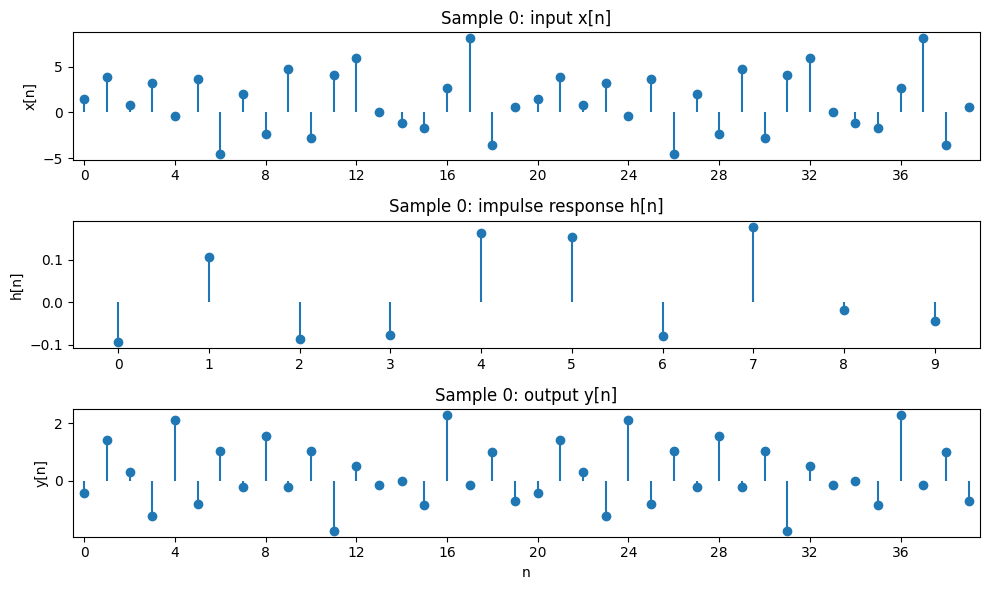

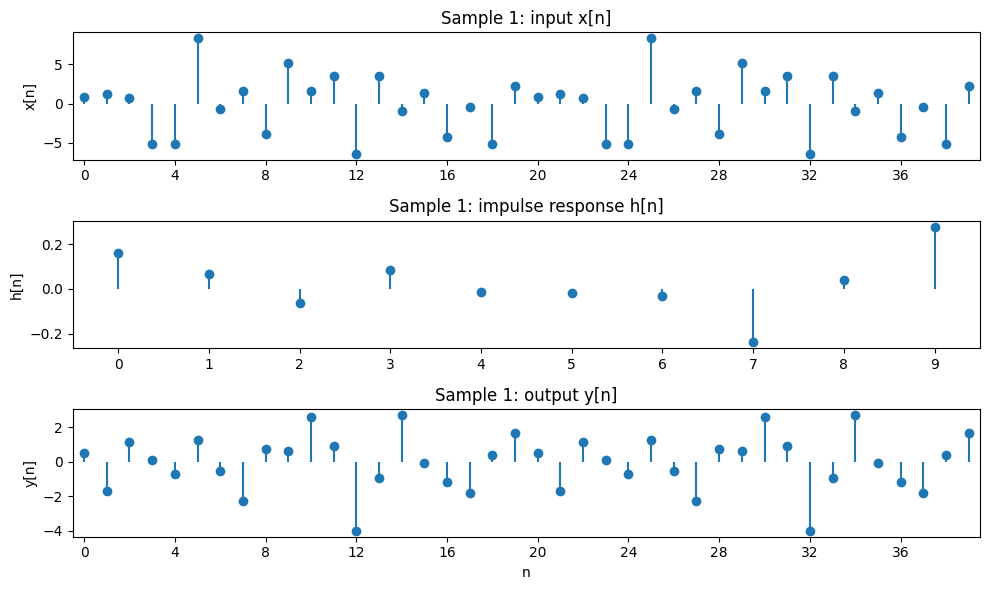

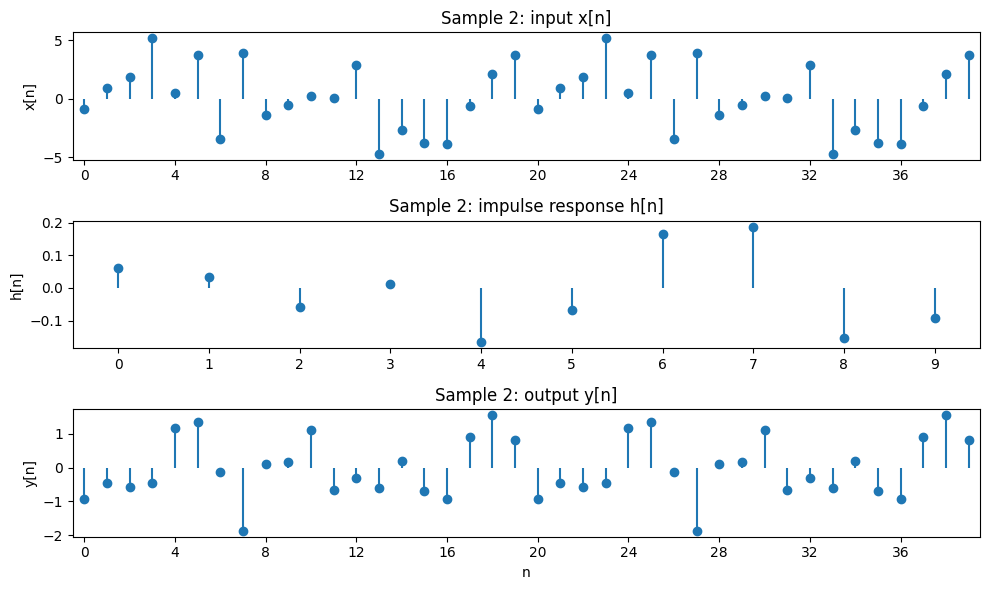

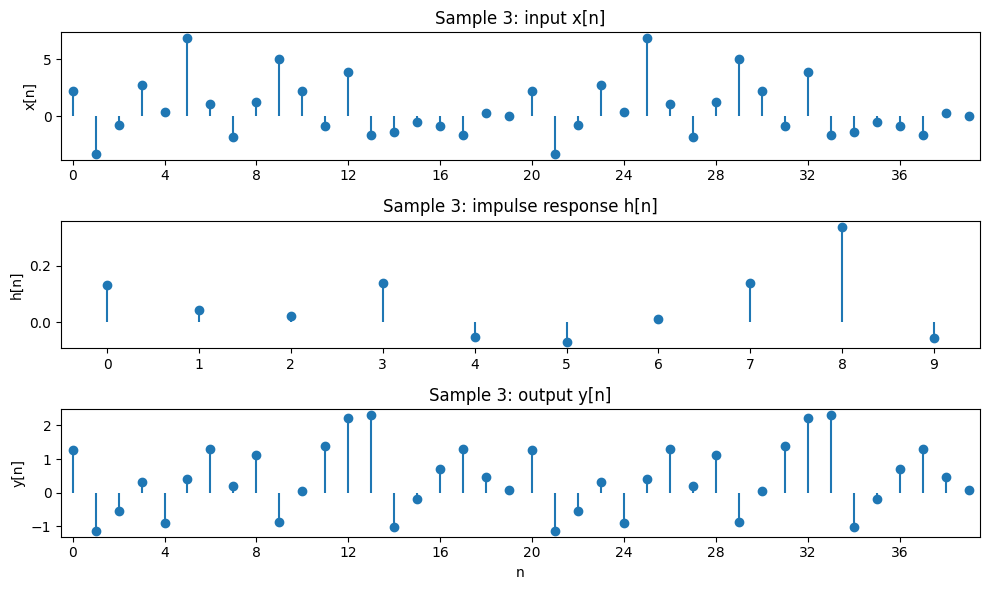

In [47]:
# User-set parameters
batch_size = 4
p = 20
fir_len = 10
device = "cpu"  # or "cuda"

# 1) Generate batch of inputs and FIRs
x_batch, h_batch = generate_batch_inputs_and_firs(
    batch_size=batch_size,
    p=p,
    fir_len=fir_len,
    amp_dist="normal",
    amp_std=1.0,
    fir_dist="normal",
    normalize_fir=True,
    num_freqs=None,   # or e.g. p//4 for band-limited
    device=device,
)

# 2) Circular convolution for each sample in batch
y_batch = circular_conv_batch_fft(x_batch, h_batch)

# 3) Plot each triple (x, h, y)
plot_batch_signals(
    x_batch,
    h_batch,
    y_batch,
    max_plots=batch_size,   # reduce if you only want to see a few
    show_two_periods=True,  # False if you only want one period on x,y
)


# OLD

In [34]:

# Reproducibility
torch.manual_seed(0)

# ==========================
# User-settable parameters
# ==========================

# Period / vector length
p = 5  # e.g. 256 samples per period

device = "cpu"  # or "cuda" if you want & have it

# ---- Amplitude distribution for A_i ----
# Option 1 (recommended): zero-mean Gaussian
amp_dist = "normal"   # "normal" or "uniform"

# For normal
amp_std = 1.0         # standard deviation of A_i

# For uniform
amp_max = 1.0         # A_i ~ U[-amp_max, amp_max]

# ---- FIR filter parameters ----
fir_len = 10          # number of taps in FIR (finite impulse response)
fir_dist = "normal"   # distribution for FIR taps: "normal" or "uniform"
normalize_fir = True  # normalize FIR taps (L1) to keep overall gain reasonable

In [35]:
# Generate periodic signal u[t] = sum_i A_i sin(ω_i t + θ_i)
# with ω_i = 2π k_i / p, k_i ∈ {0, 2, 4, ...,} up to < p

def generate_periodic_signal(p, amp_dist="normal", amp_std=1.0, amp_max=1.0, device="cpu"):
    # Time indices t = 0, 1, ..., p-1
    t = torch.arange(p, dtype=torch.float32, device=device).unsqueeze(0)  # shape (1, p)


    k_vals = torch.arange(0, p, 1, dtype=torch.float32, device=device).unsqueeze(1)
    omega = 2 * torch.pi * k_vals / p  # shape (K, 1)

    # Random phases θ_i ~ Uniform(0, 2π)
    phases = 2 * torch.pi * torch.rand_like(omega)  # shape (K, 1)

    # Amplitudes A_i
    K = k_vals.shape[0]
    if amp_dist == "uniform":
        # A_i ~ U[-amp_max, amp_max]
        amplitudes = (2 * amp_max) * torch.rand((K, 1), dtype=torch.float32, device=device) - amp_max
    else:
        # Default / recommended: A_i ~ N(0, amp_std^2)
        amplitudes = amp_std * torch.randn((K, 1), dtype=torch.float32, device=device)

    # Compute sin(ω_i t + θ_i) for all i, t using broadcasting
    sin_arg = omega * t + phases          # shape (K, p)
    sines = torch.sin(sin_arg)            # shape (K, p)

    # Weighted sum over i
    x = (amplitudes * sines).sum(dim=0)   # shape (p,)

    return x

# Generate x (the periodic input)
x = generate_periodic_signal(
    p=p,
    amp_dist=amp_dist,
    amp_std=amp_std,
    amp_max=amp_max,
    device=device,
)

x.shape

torch.Size([5])

In [36]:
# Generate FIR filter h[n] and do circular convolution so y has period p

def generate_fir(fir_len, dist="normal", device="cpu", normalize=True):
    if dist == "uniform":
        h = 2 * torch.rand(fir_len, dtype=torch.float32, device=device) - 1.0  # U[-1,1]
    else:
        # Recommended: zero-mean Gaussian taps
        h = torch.randn(fir_len, dtype=torch.float32, device=device)

    if normalize:
        # L1 normalization to keep gain ~1
        h = h / h.abs().sum()

    return h


def circular_convolution(x, h):
    """
    Circular convolution of a length-p vector x with FIR h.
    Result has length p and is p-periodic if x is p-periodic.
    """
    p = x.shape[0]
    L = h.shape[0]

    # Indices for circular convolution: (n - k) mod p
    idx_n = torch.arange(p, device=x.device).unsqueeze(1)   # shape (p,1)
    idx_k = torch.arange(L, device=x.device).unsqueeze(0)   # shape (1,L)
    idx = (idx_n - idx_k) % p                               # shape (p,L)

    # x[idx] has shape (p,L); multiply by h and sum over k
    y = (x[idx] * h) .sum(dim=1)                            # shape (p,)

    return y


# Generate FIR
h = generate_fir(
    fir_len=fir_len,
    dist=fir_dist,
    device=device,
    normalize=normalize_fir,
)

# Circular convolution to keep period p
y = circular_convolution(x, h)

x.shape, h.shape, y.shape

(torch.Size([5]), torch.Size([10]), torch.Size([5]))

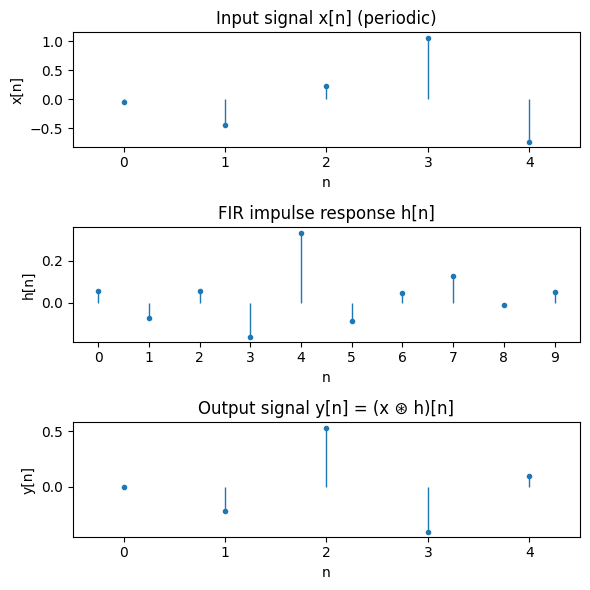

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch

# Make sure x, h, y exist

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=False)

signals = [
    (x, "Input signal x[n] (periodic)", "x[n]"),
    (h, "FIR impulse response h[n]", "h[n]"),
    (y, "Output signal y[n] = (x ⊛ h)[n]", "y[n]"),
]

for ax, (sig, title, ylabel) in zip(axes, signals):
    N = sig.shape[0]
    n = torch.arange(N)

    markerline, stemlines, baseline = ax.stem(
        n.cpu().numpy(),
        sig.cpu().numpy(),
        basefmt=" "
    )

    # Make stems look denser / closer
    ax.set_xlim(-0.5, N - 0.5)              # no extra margins
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # integer x ticks

    # Optional: tweak aesthetics a bit
    markerline.set_markersize(3)
    stemlines.set_linewidth(1.0)

    ax.set_title(title)
    ax.set_xlabel("n")
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()
